# Prediction of a Categorical Variable (defaulting on a loan or not)
  
In this example, our goal is to predict whether a customer will default on a loan or not (i.e., yes/no). But we cannot use linear regression because ‘default’ is not a continuous variable (what would a default value of -1, 0.4 or 2 mean?).  
  
Instead, we can use logistic regression, where we predict the probability (between 0 and 1) of a default occurring.  
  
The probability 𝑦 given a single feature (i.e. x1) is estimated using the logistic function:  
  
y = 1 / (1 + e^(-(β0 + β1.x1 ) ) )  
  
where β0 is a constant and β1 is a parameter (coefficient). These need to be estimated during the training process.  

## 1 Import the data
Let's look at an example using historical data on bank loan defaults.  

The following variables are included in the file ‘loan_defaults.xlsx’:  
  
- default: Whether the customer defaulted on the loan (1) or not (0)
- student: whether the customer is a student or not (Yes/No)
- balance: size the of the loan
- income: customer’s annual income

In [1]:
# Start by importing the dataset into a pandas DataFrame:
import pandas as pd
data = pd.read_csv('data/loan_defaults.csv')
data.head()

,default,student,balance,income
0,0,No,729.526495,44361.62507
1,0,Yes,817.180407,12106.13470
2,0,No,1073.549164,31767.13895
3,0,No,529.250605,35704.49394
4,0,No,785.655883,38463.49588


## 2 Preprocess the data
Regression works on numerical data, but the ‘student’ variable contains text data (i.e. ‘Yes’/’No’).

In [2]:
# Convert text data to numerical:
data = pd.get_dummies(data, drop_first = True)
data.head()

,default,balance,income,student_Yes
0,0,729.526495,44361.62507,0
1,0,817.180407,12106.13470,1
2,0,1073.549164,31767.13895,0
3,0,529.250605,35704.49394,0
4,0,785.655883,38463.49588,0


## 3 Exploratory analysis

In [3]:
# Check how many observations and variables we have:
data.shape

(10000, 4)

The label (‘default’) has two possible classes: 0 (didn’t default) and 1 (did default). We suspect that very few customers defaulted on their loans – meaning there are very few observations for customers who did default. If one class dominates the dataset, this could bias our model.

In [4]:
# Count the number of customers in each class
data['default'].value_counts()

0    9667
1     333
Name: default, dtype: int64

Next, we need to explore any relationships between ‘default’ and the other variables.

In [5]:
# Group the data by default class and calculate the average feature values for each class
data.groupby('default').mean()

,balance,income,student_Yes
default,,,
0,803.94375,33566.166625,0.291404
1,1747.82169,32089.147124,0.381381


In [6]:
# We can also calculate the correlation between ‘default’ and each of the other variables
data.corr()

,default,balance,income,student_Yes
default,1.000000,0.350119,-0.019871,0.035420
balance,0.350119,1.000000,-0.152243,0.203578
income,-0.019871,-0.152243,1.000000,-0.753985
student_Yes,0.035420,0.203578,-0.753985,1.000000


Visualise the distributions of balance for the two classes.

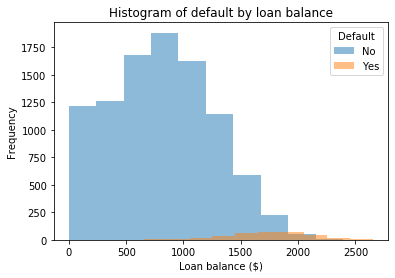

In [7]:
# Import the pyplot lib
%matplotlib inline
import matplotlib.pyplot as plt

defaultN = data.query('default == 0')
defaultY = data.query('default == 1')

defaultN.head()
defaultY.head()

plt.hist(defaultN.balance, alpha = 0.5)
plt.hist(defaultY.balance, alpha = 0.5)

plt.ylabel('Frequency')
plt.xlabel('Loan balance ($)')
plt.legend(['No', 'Yes'], title="Default")
plt.title('Histogram of default by loan balance')

plt.show()

The number of samples for "yes" is much lower than for "no", so the scale of the two distributions is very different.  If we are unsure whether the two distributions are really different or not, we might want to view the two variables as a probability density (i.e., the area under the histogram will sum to 1).

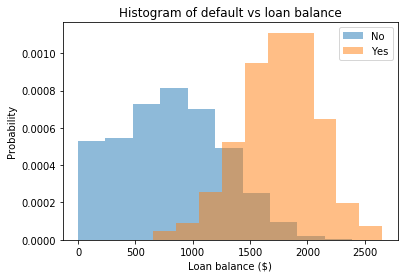

In [8]:
# Set density = True, to ignore any scaling effects.
plt.hist(defaultN.balance, alpha = 0.5, density = True)
plt.hist(defaultY.balance, alpha = 0.5, density = True)

plt.ylabel('Probability')
plt.xlabel('Loan balance ($)')
plt.legend(['No', 'Yes'])
plt.title('Histogram of default vs loan balance')

plt.show()

## 4 Train a logistic regression model
We can train a logistic regression model using sklearn.  
  
To begin with, we should reserve a subset of the dataset for final model testing.

In [9]:
# Split the data set into a training set and a testing set
from sklearn.model_selection import train_test_split

X = data[['balance', 'income', 'student_Yes']]
y = data['default']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 0, stratify = y)
print(Xtrain)

          balance       income  student_Yes
2885    62.652949  44440.70548            0
2012  1069.800340  14736.14700            1
3154  1218.638905  29899.80685            1
6851  1821.523917  15802.38929            1
7730   347.460916  24735.55069            0
...           ...          ...          ...
3779   549.191343  43688.68042            0
4414    62.237128  20267.49993            1
9684   399.118375  48889.98903            0
4805   613.156883  17665.47770            1
812     56.420712  54217.33825            0

[8000 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

Xtrain and Xtest are pandas Series, but sklearn needs them to be in an array with a single column.

This can be achieved using the 'reshape' method with the following parameters:
- Parameter 1 is set to -1: The first dimension (number of rows) of the array should be inferred from the original Series. 
- Parameter 2 is set to 1: The second dimension (number of columns) of the array should be 1.

In [10]:
#Xtrain = Xtrain.values.reshape(-1, 1)
#Xtest = Xtest.values.reshape(-1, 1)

Now we can initialise and train the model.

In [11]:
# Initialise model. 
# Because the dataset is not balanced (very few defaulters), set the ‘class_weight’ parameter to ‘balanced’:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight = "balanced")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [12]:
# Fit the model:
log_reg.fit(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Get the constant and parameter values (β_0 and β_1):
print('Model output: intercept={} coef={}'.format(log_reg.intercept_, log_reg.coef_))

Model output: intercept=[-7.00611669] coef=[[ 5.46883537e-03  1.17011616e-06 -6.55053443e-01]]


## 5 Test the logistic regression model

In [14]:
# Test the model with different values of our feature (‘balance’):
import numpy as np
balances = np.array([1000])
#log_reg.predict(balances.reshape(-1, 1))

In [15]:
# Examine the probabilities of the predictions
# P (not default), P (default)
#log_reg.predict_proba(balances.reshape(-1, 1))

## 6 Evaluate the model using scores

In [16]:
# Score the model for the training set
log_reg.score(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


0.86075

In [17]:
# Score the model for the test set
log_reg.score(Xtest, ytest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


0.866

## 7 Evaluate the model using a confusion matrix

In [18]:
# Evaluate the model using a confusion matrix
from sklearn.metrics import confusion_matrix
ytest_preds = log_reg.predict(Xtest)
confusion = confusion_matrix(ytest, ytest_preds)
print(confusion)

[[1669  264]
 [   4   63]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [19]:
# Or get the confusion matrix as true negative, false positive, false negative, true positive
tn, fp, fn, tp = confusion.ravel()
print('True Negative  = {:4}\nFalse Positive = {:4}\nFalse Negative = {:4}\nTrue Positive  = {:4}'.format(tn, fp, fn, tp))

True Negative  = 1669
False Positive =  264
False Negative =    4
True Positive  =   63


In [20]:
# Create a heatmap of the confusion matrix:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(ytest, ytest_preds)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 42.0, 'Predicted')

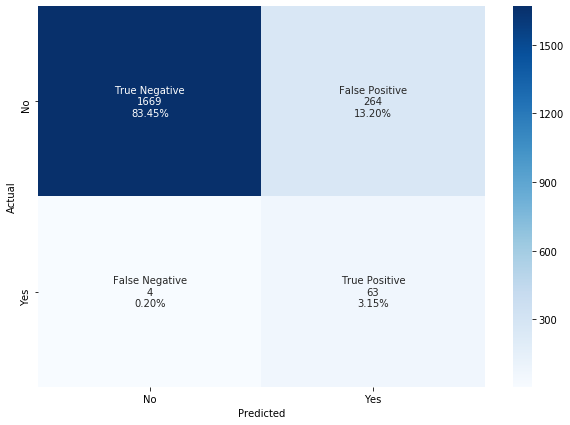

In [21]:
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (10,7))

sns.heatmap(confusion, annot = labels, fmt = '' , cmap = 'Blues',
            xticklabels = ['No', 'Yes'],
            yticklabels = ['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

## 8 Evaluate the model using a classification report

In [22]:
# Obtain some summary statistics from a classification report
from sklearn.metrics import classification_report
print(classification_report(ytest, ytest_preds))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      1933
           1       0.19      0.94      0.32        67

    accuracy                           0.87      2000
   macro avg       0.60      0.90      0.62      2000
weighted avg       0.97      0.87      0.91      2000

